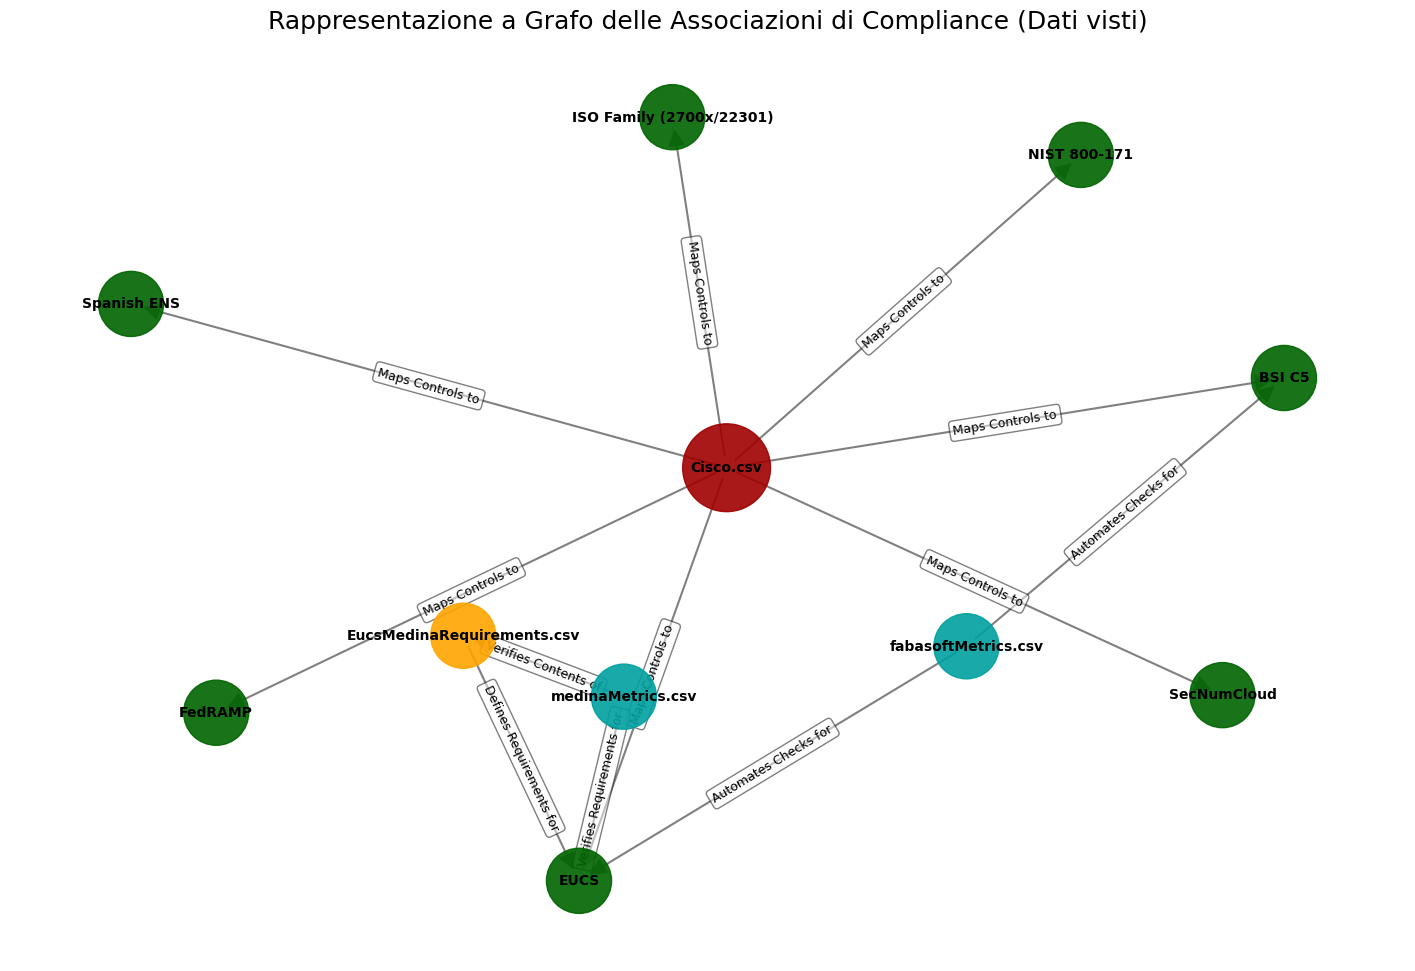

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Definizione delle Relazioni basate sulle due colonne specificate
# Usiamo i nomi semplificati per gli schemi esterni multipli (es. "ISO Family").
relazioni_compliance = [
    # Cisco CCF: Mappa la maggior parte degli standard globali (HUB)
    ('Cisco.csv', 'ISO Family (2700x/22301)', 'Maps Controls to'),
    ('Cisco.csv', 'BSI C5', 'Maps Controls to'),
    ('Cisco.csv', 'NIST 800-171', 'Maps Controls to'),
    ('Cisco.csv', 'EUCS', 'Maps Controls to'),
    ('Cisco.csv', 'SecNumCloud', 'Maps Controls to'),
    ('Cisco.csv', 'FedRAMP', 'Maps Controls to'),
    ('Cisco.csv', 'Spanish ENS', 'Maps Controls to'),
    
    # EucsMedinaRequirements: Definisce i requisiti EUCS
    ('EucsMedinaRequirements.csv', 'EUCS', 'Defines Requirements for'),
    
    # medinaMetrics: Verifica i requisiti EUCS
    ('medinaMetrics.csv', 'EUCS', 'Verifies Requirements for'),
    
    # fabasoftMetrics: Metriche automatizzate (Implica l'uso su BSI C5 ed EUCS)
    ('fabasoftMetrics.csv', 'EUCS', 'Automates Checks for'),
    ('fabasoftMetrics.csv', 'BSI C5', 'Automates Checks for'),

    # Relazione implicita tra i file MEDINA (Verifiche vs Requisiti)
    ('medinaMetrics.csv', 'EucsMedinaRequirements.csv', 'Verifies Contents of')
]

# 2. Creazione del Grafo e Classificazione dei Nodi
G = nx.DiGraph()
for source, target, label in relazioni_compliance:
    G.add_edge(source, target, relationship=label)

def get_node_type(node):
    if node == 'Cisco.csv': return 'Cisco CCF (HUB)'
    if node.endswith('Requirements.csv'): return 'Requirements Catalog (EUCS)'
    if node.endswith('Metrics.csv'): return 'Metrics Catalog (MEDINA/FABASOFT)'
    return 'External Standard'

node_colors = []
node_size = []
color_map = {
    'Cisco CCF (HUB)': '#A00000', # Rosso Scuro per il perno centrale
    'Requirements Catalog (EUCS)': '#FFA500', # Arancione per i Requisiti
    'Metrics Catalog (MEDINA/FABASOFT)': '#00A0A0', # Verde Acqua per le Metriche
    'External Standard': '#006400', # Verde Scuro per gli Standard
}

for node in G.nodes():
    node_type = get_node_type(node)
    node_colors.append(color_map[node_type])
    node_size.append(4000 if 'Cisco' in node else 2200)

# 3. Visualizzazione
plt.figure(figsize=(18, 12))
pos = nx.spring_layout(G, k=0.8, iterations=50) 

# Disegno dei nodi e dei bordi
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=25, width=1.5)

# Aggiunta delle etichette dei nodi
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='black')

# Aggiunta delle etichette dei bordi (relazioni)
edge_labels = nx.get_edge_attributes(G, 'relationship')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=9, bbox={"alpha":0.5, "boxstyle":"round", "facecolor":"white"})

plt.title("Rappresentazione a Grafo delle Associazioni di Compliance (Dati visti)", fontsize=18)
plt.axis('off')
plt.show()